# HW 10 CLUSTERING BUSINESS
##cluster time trends in NYC businesses: 

# Clean data

In [3]:
import matplotlib.pyplot as plt
import os
import json
import urllib2
import numpy as np
import pandas as pd
import zipfile
%pylab inline
import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from descartes import PolygonPatch
url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson" 
nyjason = json.load(urllib2.urlopen(url))

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [7]:
zips = []
for department in nyc['features']:
    nyc_zip.append(str(department['properties']["postalCode"]))
#print zips

NameError: name 'nyc' is not defined

In [175]:
tr0 = range(1994,2014)
tr1 = range(1998,2003)
ffname = "zbp{0}totals.zip"
biz_zip = set()
for i in tr0:
    if i in tr1:
        st = str(i)[2:]
        fname = ffname.format(st)
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')),dtype={'ZIP':str})
        df.columns=[u'zip', u'name', u'empflag', u'emp', u'qp1', u'ap', u'est']
    else:
        st = str(i)[2:]
        fname = ffname.format(st)
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')),dtype={'zip':str})
    new_zip = set(df.zip).intersection(set(zips))
    biz_zip = biz_zip.union(new_zip)

In [176]:
biz_zip = sorted(biz_zip)

In [177]:
biz_data_est = pd.DataFrame(np.nan,index=biz_zip,columns=tr0)

In [178]:
for i in tr0:
    if i in tr1:
        st = str(i)[2:]
        fname = ffname.format(st)
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')),dtype={'ZIP':str})
        df.columns=[u'zip', u'name', u'empflag', u'emp', u'qp1', u'ap', u'est']
    else:
        st = str(i)[2:]
        fname = ffname.format(st)
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')),dtype={'zip':str})
    for j in biz_zip:
        if j in list(set(df.zip)):
            biz = df[df.zip==j]
            biz_data_est.loc[j][i]=int(biz.est)

In [179]:
biz_data_est = biz_data_est.dropna()

In [180]:
biz_zip = biz_data_est.index

In [181]:
biz_data_est.to_csv('data.csv',index_label='zip')

In [182]:
df = pd.read_csv('data.csv',index_col='zip')
b2 = df
df1 = df.copy()
print df

       1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  2005  \
zip                                                                             
10001  6999  7088  7075  7154  7254  7233  7317  7188  7141  7084  7370  7312   
10002  1784  1819  1919  2049  2003  2085  2277  2543  2269  2402  2551  2682   
10003  3256  3377  3417  3535  3649  3659  3683  3602  3616  3704  3776  3867   
10004  1115  1124  1133  1173  1176  1233  1294  1247  1253  1252  1283  1260   
10005  1076  1109  1216  1227  1270  1242  1287  1249  1244  1200  1226  1214   
10006  1061  1002   969   990  1030  1059  1067  1026   934   862   869   870   
10007  1307  1274  1254  1287  1282  1303  1327  1233  1620  1603  1635  1311   
10009   634   633   673   747   786   804   860   869   921   953   982  1029   
10010  3019  2987  3029  3112  3152  3143  3203  3178  3085  3045  3059  3060   
10011  3301  3340  3392  3541  3599  3664  3653  3592  3682  3711  3729  3784   
10012  2385  2485  2531  267

In [183]:
wb2 = b2.copy()
for i in range(len(b2)):
    wb2.iloc[i] = (wb2.iloc[i]-np.mean(wb2.iloc[i]))/np.std(wb2.iloc[i])

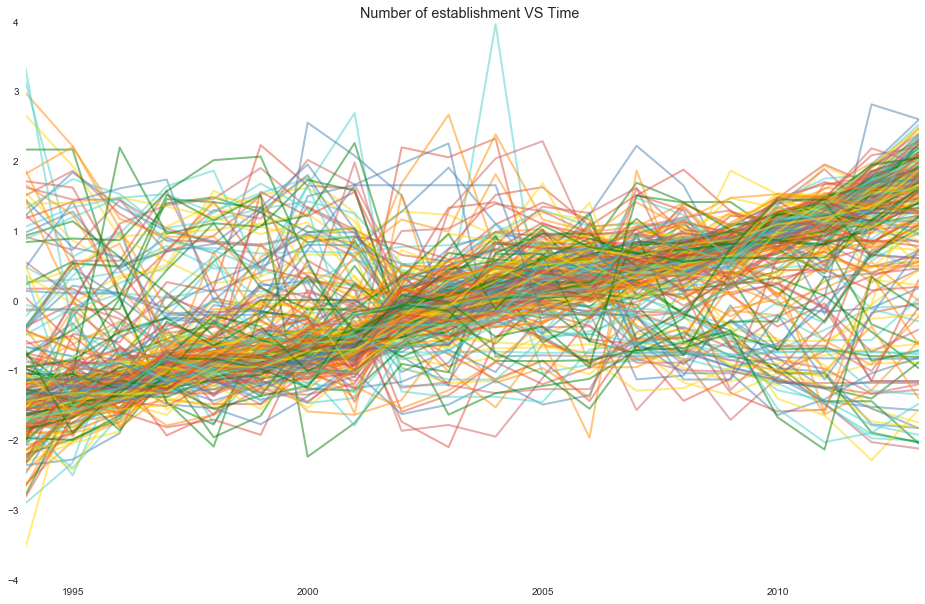

In [184]:
plt.figure(figsize=(16,10))
plt.xlim(1994,2013)
for i in range(len(wb2)-1):
    plt.plot(wb2.iloc[i].index, wb2.iloc[i], '-', alpha=0.5)
plt.title('Number of establishment VS Time ')

In [185]:
wb2 = wb2.dropna()

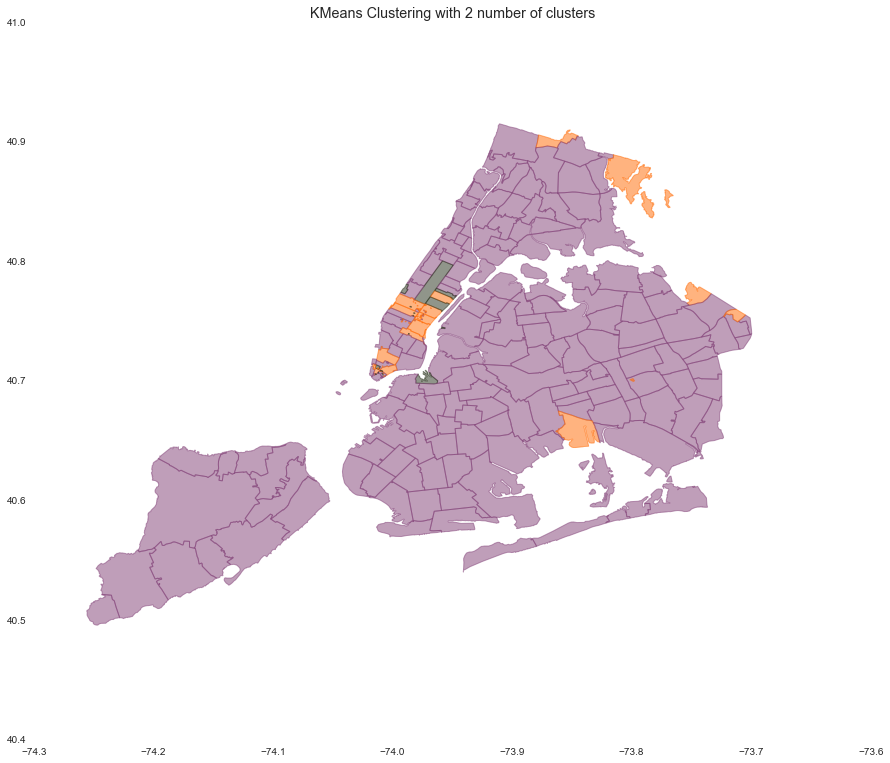

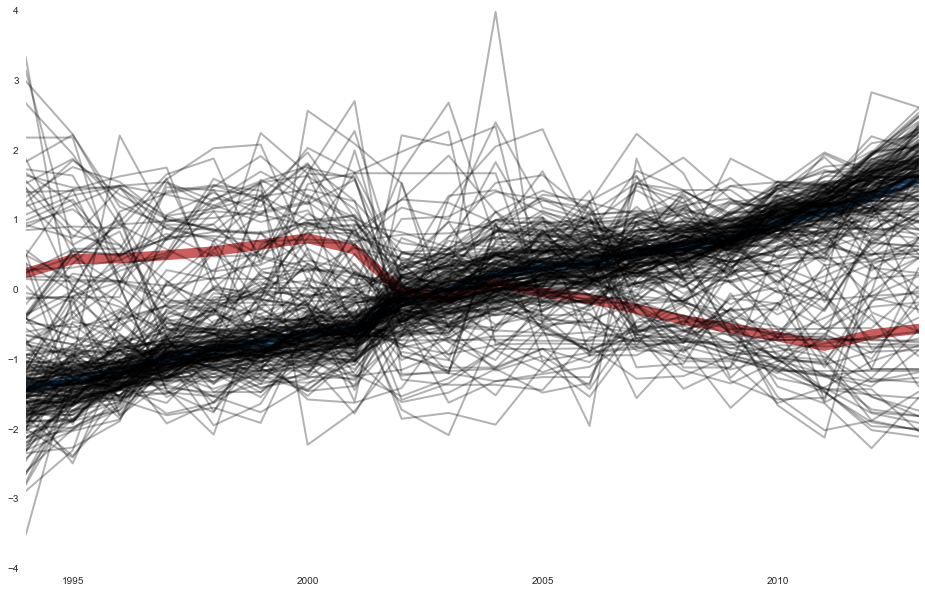

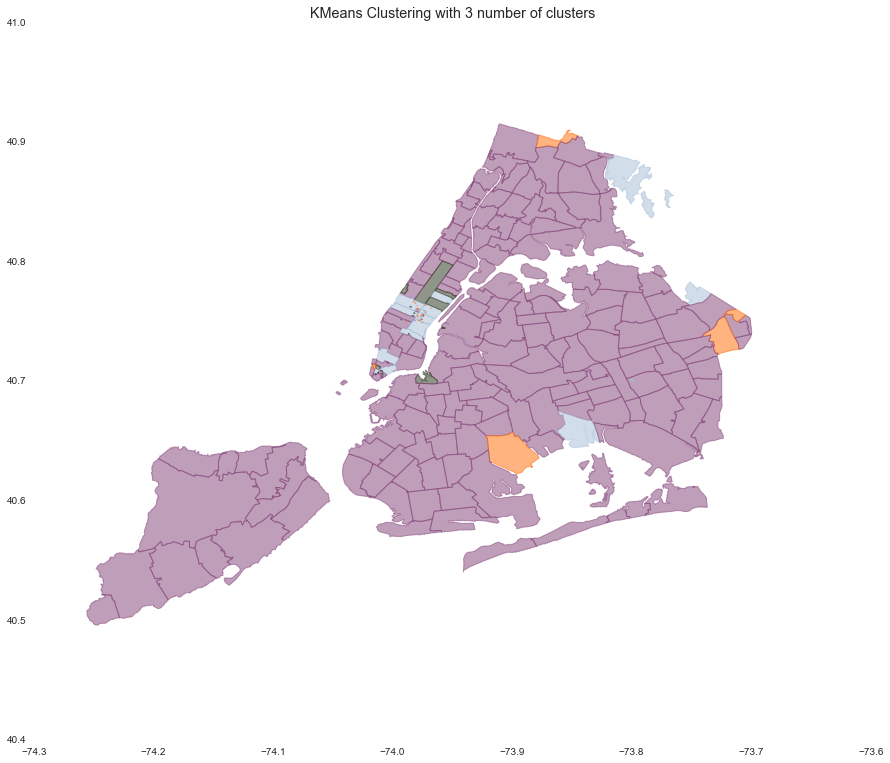

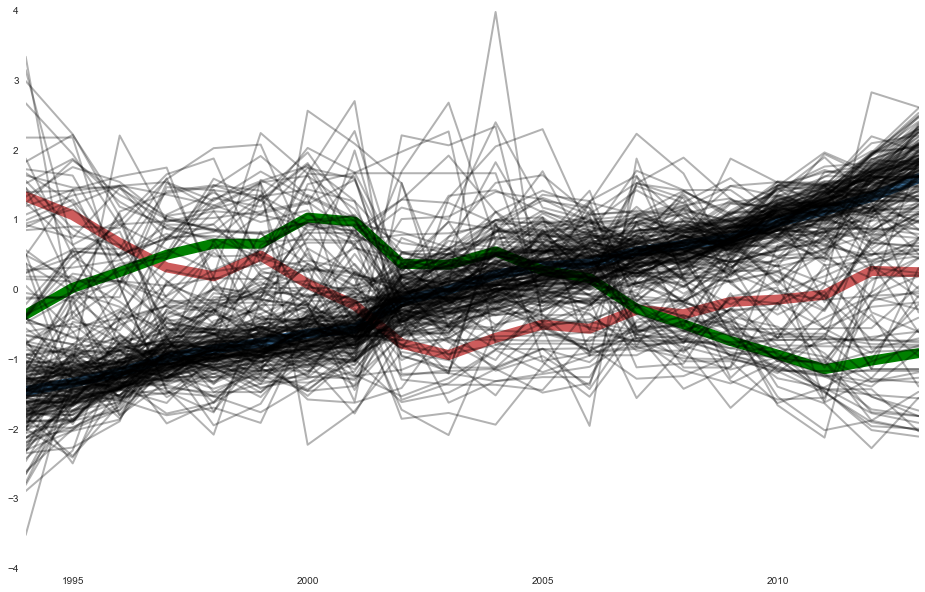

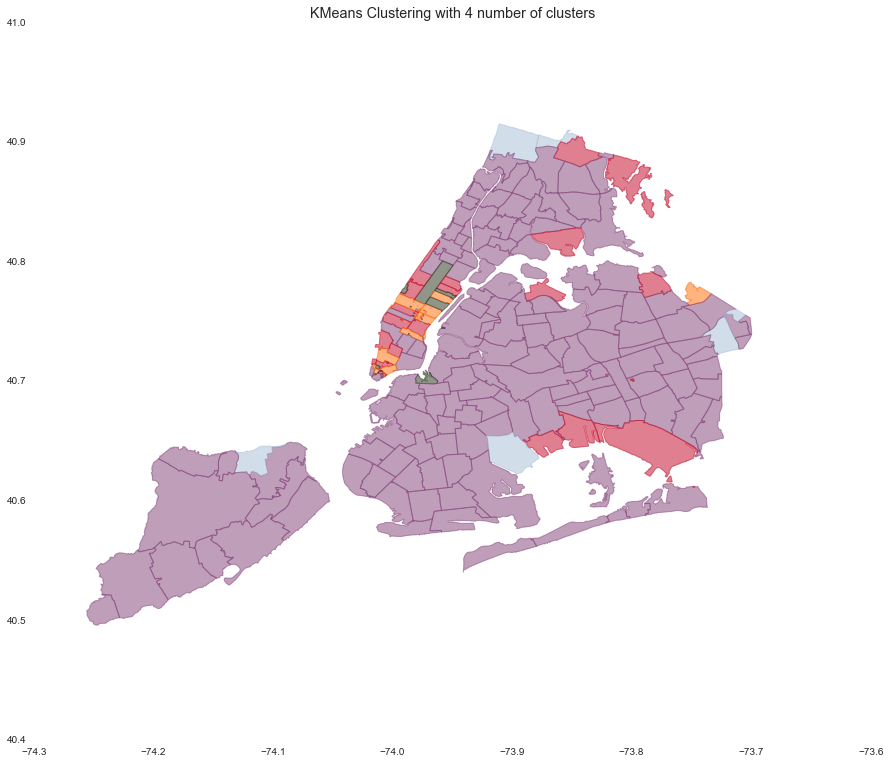

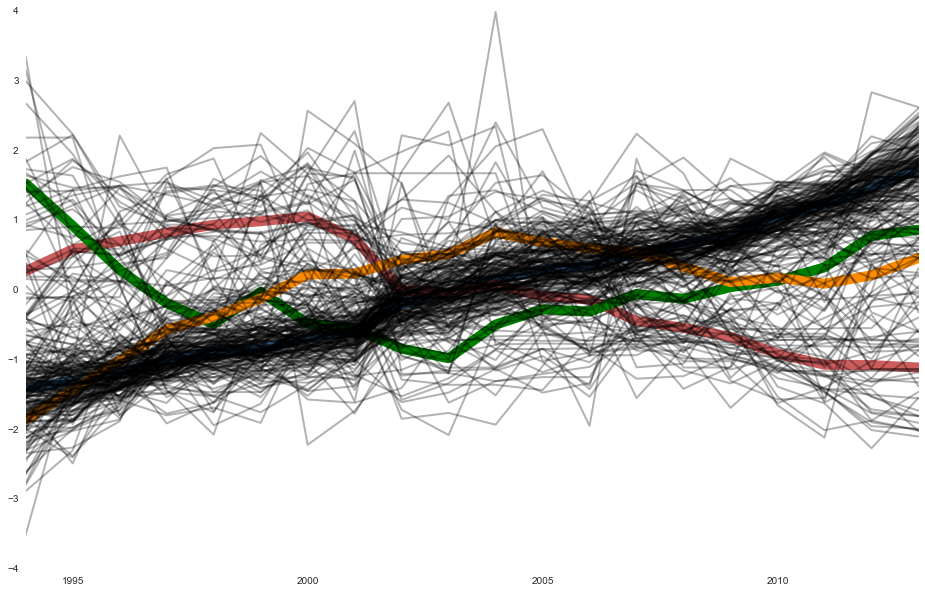

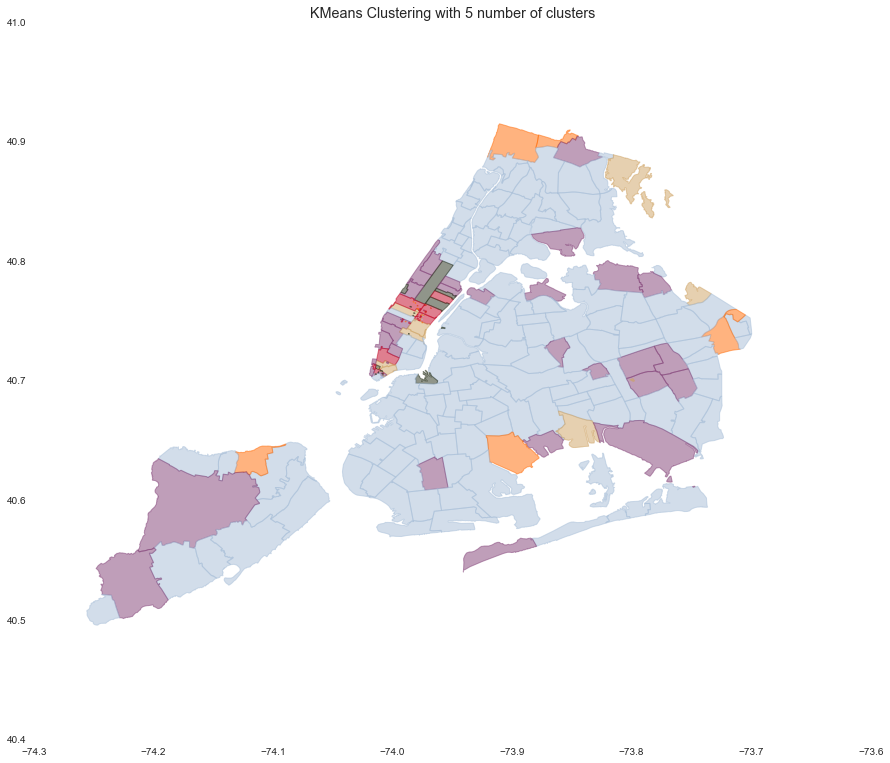

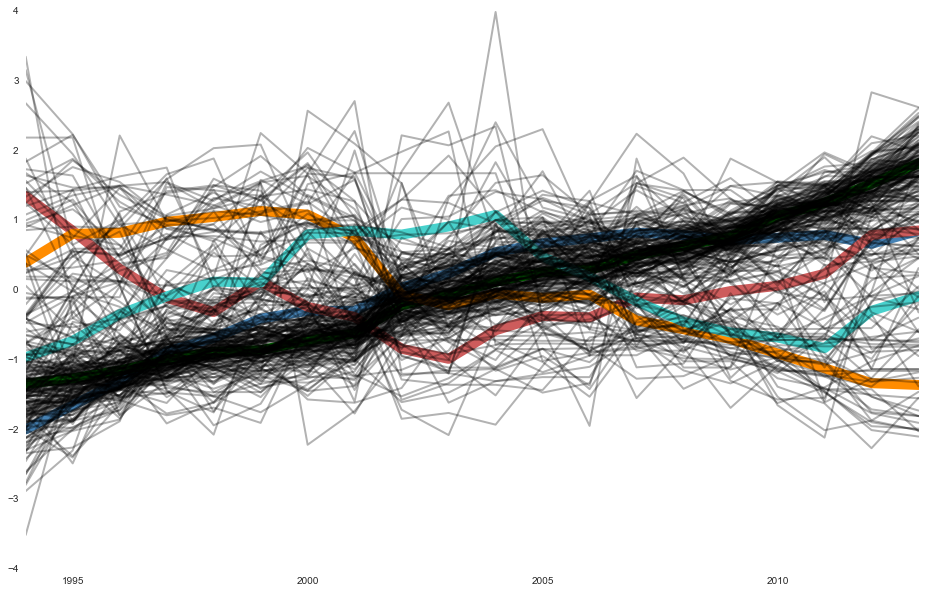

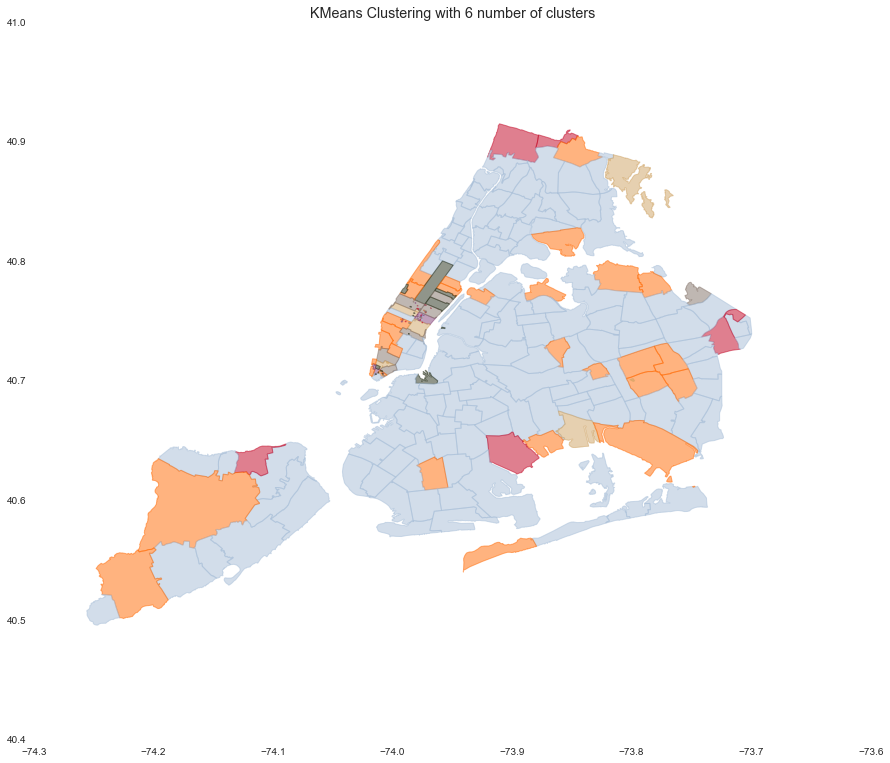

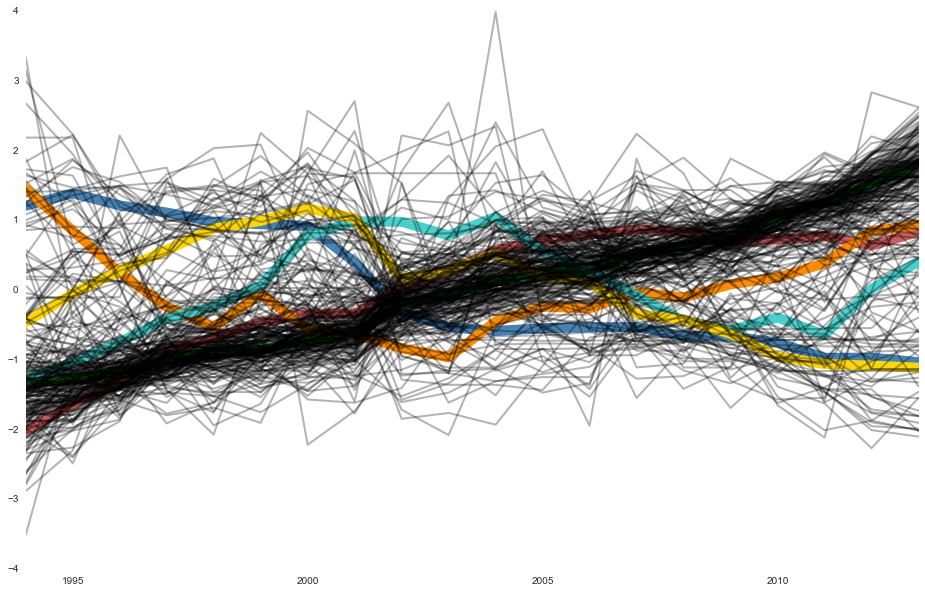

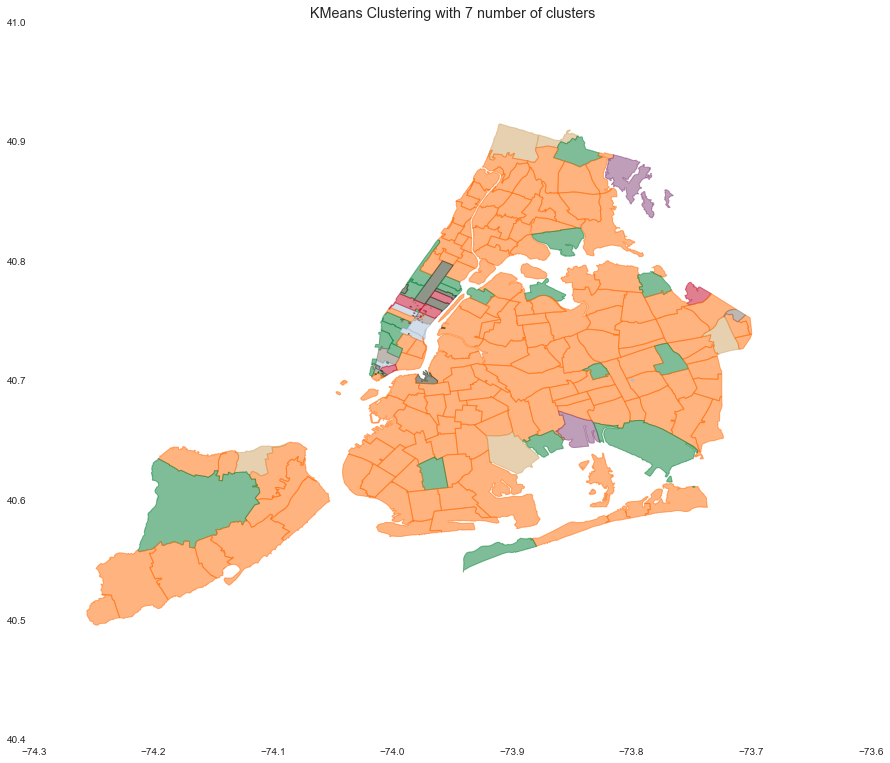

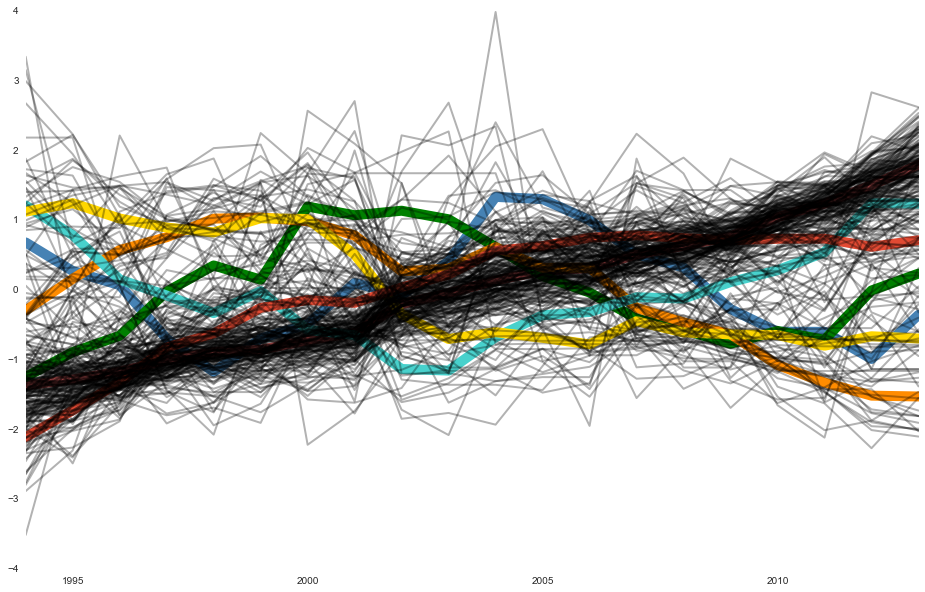

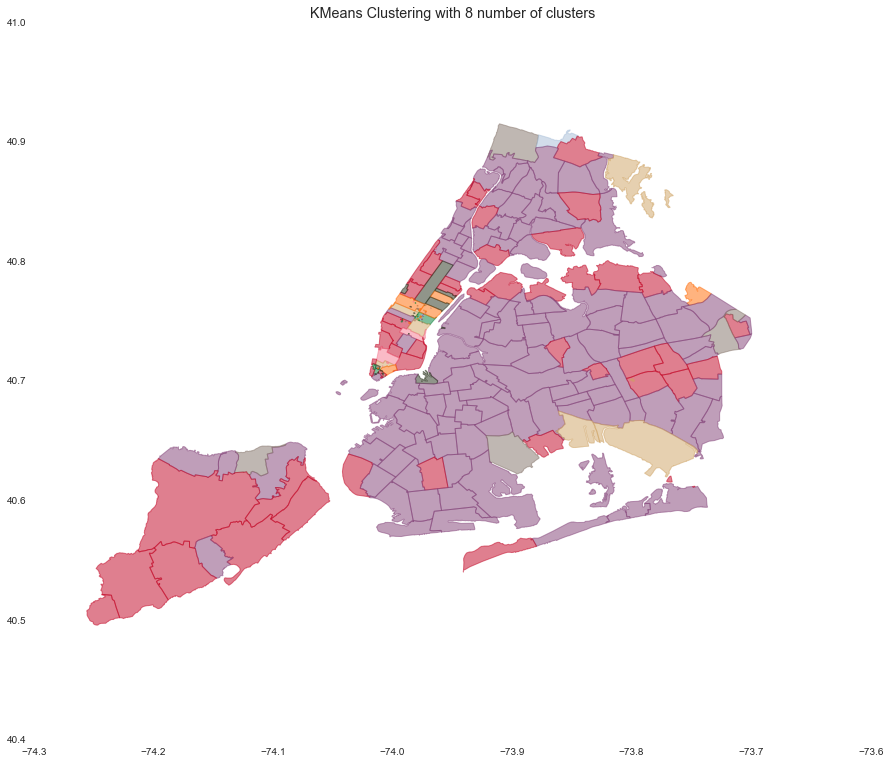

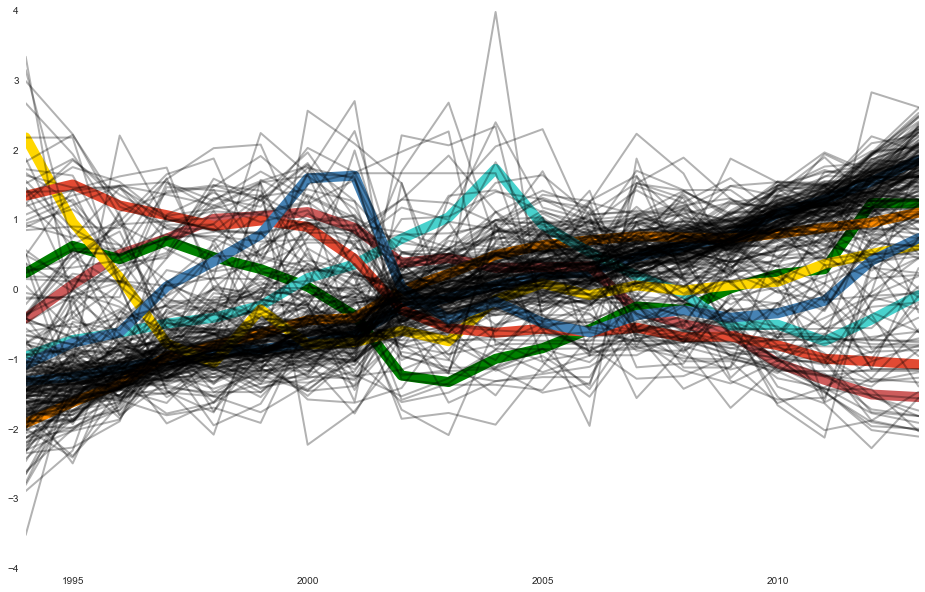

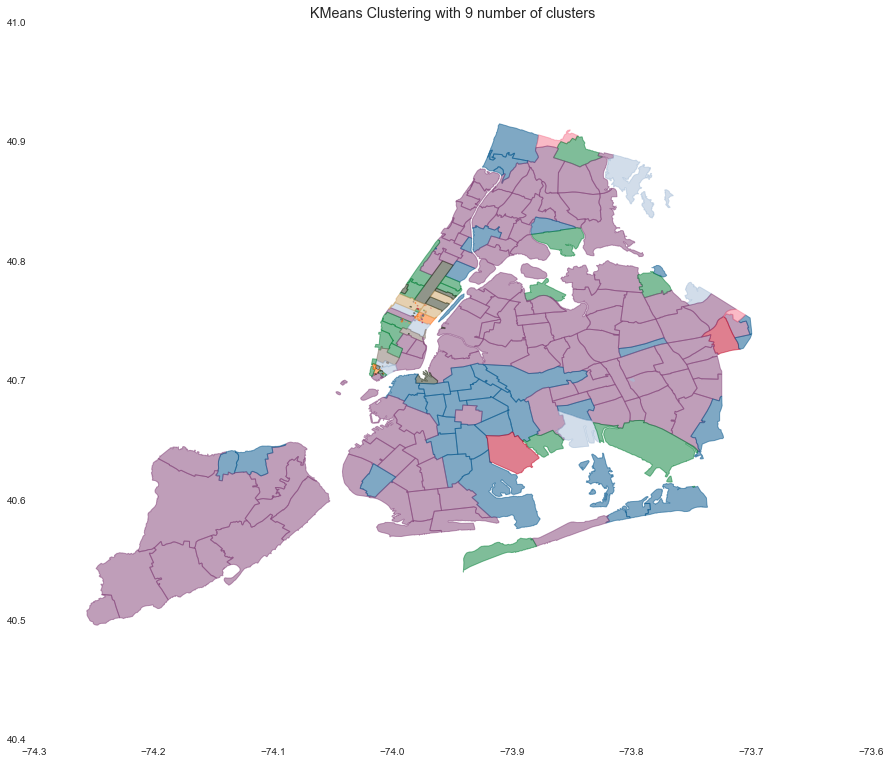

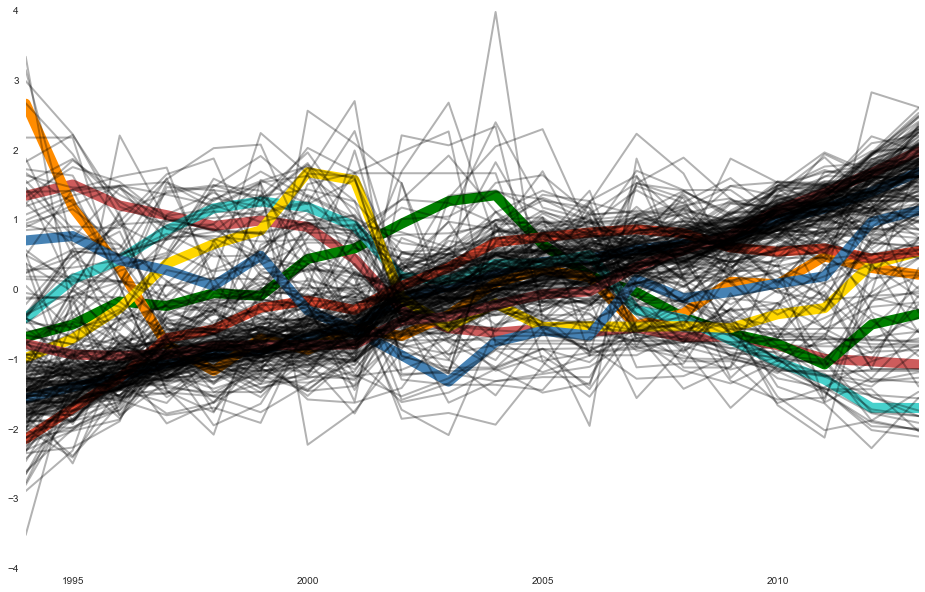

In [186]:
silhouette_scores = {}
for n_c in range(2,10):
    kmeans = sklearn.cluster.KMeans(n_clusters=n_c)
    kmeans.fit(wb2.values)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_    
    silhouette_avg = silhouette_score(wb2.values, kmeans.labels_)
    silhouette_scores[n_c] = silhouette_avg
    cluster = labels
    clustered_zips = pd.DataFrame({'zip':wb2.index, 'cluster':cluster})
    fig = plt.figure(figsize=(15,15)) 
    for i in nyjason['features']:
        poly = i['geometry']
        postcode = int(i['properties']['postalCode'])
        ax = fig.gca()
        GREEN = kelly_colors_hex[19]
        if postcode in list(wb2.index):
            color = kelly_colors_hex[int(clustered_zips[clustered_zips['zip']==postcode]['cluster'])+1]
            ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
        else:
            ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
    ax.axis('scaled')
    import matplotlib.patches as mpatches

    ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
    plt.legend()
    plt.title('KMeans Clustering with %s number of clusters'%(n_c))
    plt.figure(figsize=(16,10))
    plt.xlim(1994,2013)
    for i in range(len(centers)):
        plt.plot(range(1994,2014),centers[i],linewidth=10) 
    for i in range(len(wb2)):
        plt.plot(wb2.iloc[i].index, wb2.iloc[i],'k',alpha=0.3)

[-1  0  1  2]
Silhouette Coefficient: 0.415072077399
Estimated number of clusters: 3


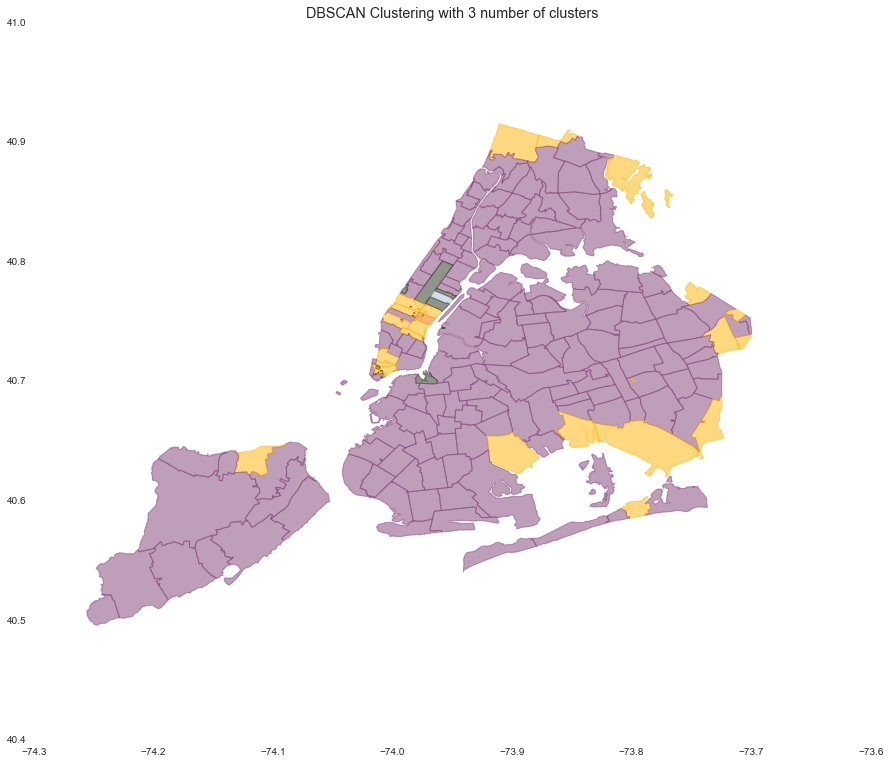

In [187]:
db = DBSCAN(eps=2).fit(wb2.values) 
labels = (db.labels_).astype(int)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print(unique(labels))
print("Silhouette Coefficient: %s" % silhouette_score(wb2.values, labels))
print('Estimated number of clusters: %d' % n_clusters)

cluster = labels
clustered_zips = pd.DataFrame({'zip':wb2.index, 'cluster':cluster})
fig = plt.figure(figsize=(15,15)) 
for i in nyjason['features']:
    poly = i['geometry']
    postcode = int(i['properties']['postalCode'])
    ax = fig.gca()
    GREEN = kelly_colors_hex[19]
    if postcode in list(wb2.index):
        color = kelly_colors_hex[int(clustered_zips[clustered_zips['zip']==postcode]['cluster'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
ax.axis('scaled')
import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
plt.legend()
plt.title('DBSCAN Clustering with %s number of clusters'%(n_clusters))

## Based on visual comparision, it looks like that KMeans and DBSCAN clustering provide very similar results.
